# load data

In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
global i,pi
i = complex(0,1)
pi = np.pi

In [4]:
rng = 0

In [5]:
def nosign(x):
    return np.sign(x)*x

# load data

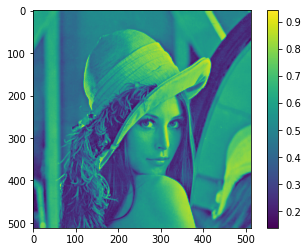

In [6]:
original = plt.imread('lenna.tiff')/255
original = (original[:,:,0]+ original[:,:,1]+ original[:,:,2])/3
plt.imshow(original)
plt.colorbar()
plt.show()

# change size to a power of two

In [7]:
original_dim = original.shape
original_numel = original.size

powerof2 = np.ceil(np.log2(original_dim))
original_dim = [int(x) for x in 2**powerof2]
original_dim

[512, 512]

# take samples

In [8]:
sample_fraction = 0.05
sample_numel = int(original_numel*sample_fraction)
sampleIDX_linear = np.random.default_rng(rng).choice(original_numel, size=sample_numel, replace=False)
sampleIDX = np.unravel_index(sampleIDX_linear, original_dim)
samples = original[sampleIDX]

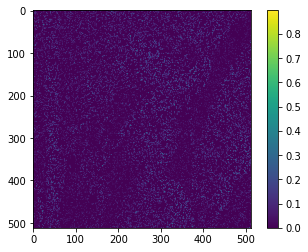

In [9]:
sampled_image = np.zeros(original_dim)
sampled_image[sampleIDX] = samples
plt.imshow(sampled_image)
plt.colorbar()
plt.show()

# preprocess samples

In [10]:
mean = samples.mean()
samples -= mean
std = samples.std()
samples /= std

# train test split

In [11]:
test_fraction = 0.1
test_numel = int(sample_numel*test_fraction)
testIDX_linear = np.random.default_rng(rng).choice(sample_numel, size=test_numel, replace=False)
testIDX = np.unravel_index(testIDX_linear, original_dim)
testData = original[testIDX]

train_numel = sample_numel - test_numel
trainIDX = np.ones(original_dim); trainIDX[testIDX]=0; trainIDX = np.where(trainIDX)
trainData = original[trainIDX]

# delete original data

In [12]:
del original

# compressed sensing theory

# compressed sensing implementation

In [13]:
#import pywt
#from scipy.fftpack import dct,idct
class CS:
    
    
    def __init__(self, **kwargs):
        
        #shape of original signal
        self.dim = kwargs['dim']
        ### coefficients
        self.xr = np.zeros(self.dim,dtype=complex) # computed coefficients - permanently updated
        ### full signal
        #self.yr = np.zeros(self.dim,dtype=complex)
        ### measurements
        self.strain = kwargs['strain'] #known const train measurements
        if 'stest' in kwargs:
            self.stest = kwargs['stest'] #known const test measurements
        else:
            self.stest = 0
        
        #predicted train measurements - permanently updated
        self.sr = np.zeros(np.size(kwargs['strain']),dtype=complex)
        #gradient - permanently updated
        self.grad = np.zeros(self.dim,dtype=complex)
        
        return None
    
    def set_trafos(self, **kwargs):
        self.forward_trafo = kwargs['phi']
        self.inverse_trafo = kwargs['iphi']
        self.signal_measurement = kwargs['psi']
        self.inverse_measurement = kwargs['ipsi']
        self.testdata_measurement = kwargs['test_psi']
        return None
    
    def set_parameters(self, **kwargs):
        
        #print error at each iteration
        if 'verbose' in kwargs:
            self.verbose = kwargs['verbose']
        else:
            self.verbose = True
        
        #minimal gradient step
        if 'step' in kwargs:
            self.step = kwargs['step']
        else:
            self.step = 1e+5
        
        #minimal gradient step
        if 'coeff' in kwargs:
            self.coeff = kwargs['coeff']
        else:
            self.coeff = np.maximum( np.prod(dim)/100 , 10 )
        
        #minimal gradient step
        if 'min_step' in kwargs:
            self.min_step = kwargs['min_step']
        else:
            self.min_step = 1e-5
        
        #maximal error
        if 'error_threshold' in kwargs:
            self.error_threshold = kwargs['error_threshold']
        else:
            self.error_threshold = 1
        
        # stop step search after ... tries
        if 'maxstepsearch' in kwargs:
            self.maxstepsearch = kwargs['maxstepsearch']
        else:
            self.maxstepsearch = 10
        
        return None
    
    def train_error(self, sr):
        return np.sum( (sr-self.strain)*np.conj(sr-self.strain) )/np.sum(self.strain*np.conj(self.strain))
    
    def test_error(self, sr):
        return np.sum( (sr-self.stest)*np.conj(sr-self.stest) )/np.sum(self.stest*np.conj(self.stest))
    
    def executeCS(self, iterations):
        self.errors = []; #iteration errors - new errors appended
        self.initial_guess()
        self.iterate(iterations)
        return self.errors
    
    def reduce_coeff(self, xx):
        max_idx = np.argsort(-np.abs(xx),axis=0) # sort coefficient, return indices
        xr = np.zeros(self.dim,dtype=complex) # [x] zero-filled coefficients
        xr[max_idx[0:self.coeff,:]] = xx[max_idx[0:self.coeff,:]] # sparse coefficient vector
        return xr
        
    def initial_guess(self):
        # guess coefficients
        xr = self.forward_trafo( self.inverse_measurement(self.strain) )
        self.xr = self.reduce_coeff(xr)
        yr = self.inverse_trafo( self.xr )
        self.sr = self.signal_measurement(yr)
        self.errors = [ self.train_error(self.sr) ]
        if self.verbose:
            print(str(round(self.step,5)).zfill(12),round(self.errors[0],8))
        return None

    def compute_grad(self):
        error = self.sr - self.strain
        error = np.minimum( np.maximum( error , np.min(error)*0.9 ) , np.max(error)*0.9 )
        grad = self.forward_trafo( self.inverse_measurement( error ) ) # correct residual error
        self.grad = grad*(1/np.max(np.abs(grad))) # normalize gradient
        return None

    def grad_descent(self):
        xr_next = self.xr-self.step*self.grad
        xr_next = self.reduce_coeff(xr_next)
        yr = self.inverse_trafo( xr_next )
        sr_next = self.signal_measurement(yr)
        new_error = self.train_error(sr_next)
        if self.verbose:
            print(str(round(self.step,5)).zfill(12),round(new_error,8))
        return new_error,xr_next,sr_next

    def iterate(self, iterations):
        for iteration in range(1,iterations+1):
            if self.verbose:
                print('----------',str(iteration),'----------')
            self.compute_grad()
            [new_error,xr_next,sr_next] = self.grad_descent()

            # adjust step length for gradient descent
            count=0
            while ( new_error < self.error_threshold ) and ( new_error > self.errors[-1] ) and ( self.step > self.min_step ) and ( count < self.maxstepsearch ):
                count += 1
                self.step = self.step*0.6
                
                [new_error,xr_next,sr_next] = self.grad_descent()
                
            if ( new_error < self.errors[-1] ):
                self.xr = xr_next
                self.sr = sr_next
                self.errors.append( new_error )
            else:
                if self.verbose:
                    print('error diverges')
                return None
        
        return None
    
    def plot_errors(self):
        plt.figure(figsize=(5,3),dpi=200)
        plt.plot(self.errors)
        plt.show()
        return None
    
    def reconstruct_traindata(self):
        yr = self.inverse_trafo( self.xr ) # [y = phi @ x] reconstructed data
        sr = self.signal_measurement(yr)
        if self.verbose:
            print('traindata_error: ',self.train_error(sr))
        return sr
    
    def reconstruct_testdata(self):
        yr = self.inverse_trafo( self.xr ) # [y = phi @ x] reconstructed data
        sr = self.testdata_measurement(yr)
        if self.verbose:
            print('testdata_error: ',self.test_error(sr))
        return sr
    
    def return_signal_and_error(self):
        yr = self.inverse_trafo( self.xr ) # [y = phi @ x] reconstructed data
        trainERROR = self.train_error( self.signal_measurement(yr) )
        testERROR = self.test_error( self.testdata_measurement(yr) )
        return yr , trainERROR , testERROR

# apply CS

In [14]:
# create CS instance with data
myCS = CS(dim=original_dim, strain=trainData, stest=testData)

In [15]:
#set transformations

### forward_trafo(yr): # [x = phi @ y] calc coefficients
#phi = lambda yr: np.fft.fft( yr ,axis=0)
#phi = lambda yr: compress_real_fft_coeff_1D( np.fft.fft( yr ,axis=0) ,axis=0)
#phi = lambda yr: dct( yr , norm='ortho',axis=0)
phi = lambda yr: np.fft.fft2( yr )
#phi = lambda yr: compress_real_fft_coeff_2D( np.fft.fft2( yr ) )
'''
import pywt
global wavelet_type, wavelet_level, wavelet_shape
wavelet_type = 'sym20'
wavelet_level = 4
#[temp,wavelet_shape] = pywt.coeffs_to_array( pywt.wavedec( np.squeeze(np.zeros(original_dim)) , wavelet_type, mode='periodization', level=wavelet_level, axis=0) )
[temp,wavelet_shape] = pywt.coeffs_to_array( pywt.wavedec2( np.squeeze(np.zeros(original_dim)) , wavelet_type, mode='periodization', level=wavelet_level) )
del temp
#phi = lambda yr: pywt.coeffs_to_array( pywt.wavedec( np.squeeze(yr) , wavelet_type, mode='periodization', level=wavelet_level, axis=0) )
phi = lambda yr: pywt.coeffs_to_array( pywt.wavedec2( np.squeeze(yr) , wavelet_type, mode='periodization', level=wavelet_level) )[0]
'''


### inverse_trafo(xr): # [y = phi @ x] reconstructed data
#iphi = lambda xr: np.fft.ifft( xr ,axis=0)
#iphi = lambda xr: decompress_real_fft_coeff_1D( np.fft.ifft( xr ,axis=0) ,axis=0)
#iphi = lambda xr: idct( xr , norm='ortho',axis=0)
iphi = lambda xr: np.fft.ifft2( xr )
#iphi = lambda xr: decompress_real_fft_coeff_1D( np.fft.ifft2( xr ) )
'''
#iphi = lambda xr: np.reshape( pywt.waverec( pywt.array_to_coeffs( np.squeeze(xr) , wavelet_shape, output_format='wavedec') , wavelet_type, mode='periodization', axis=0) ,[-1,1])
iphi = lambda xr: pywt.waverec2( pywt.array_to_coeffs( np.squeeze(xr) , wavelet_shape, output_format='wavedec2') , wavelet_type, mode='periodization')
'''


### signal_measurement(yr): # measure: return train samples
psi = lambda yr: yr[trainIDX]
#psi = lambda yr: yr[sampleIDX]



### inverse_measurement(sr): # inverse measurement: zero-filled array with samples
def ipsi(sr):
    yr = np.zeros(original_dim,dtype=complex)
    yr[trainIDX] = sr
    #yr[sampleIDX] = sr
    return yr



### testdata_measurement(yr): # measure: return test samples
test_psi = lambda yr: yr[testIDX]
#test_psi = lambda yr: 0



myCS.set_trafos(phi=phi ,iphi=iphi ,psi=psi ,ipsi=ipsi ,test_psi=test_psi)

In [16]:
# set parameters 
myCS.set_parameters(verbose=True, step=50, coeff=10, min_step=1e-5,
                    error_threshold=1, maxstepsearch=10)

<ipython-input-13-97374fdf4862>:102: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print(str(round(self.step,5)).zfill(12),round(self.errors[0],8))
<ipython-input-13-97374fdf4862>:119: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print(str(round(self.step,5)).zfill(12),round(new_error,8))


000000000050 (0.00036573+0j)
---------- 1 ----------
000000000050 (0.00035487+0j)
---------- 2 ----------
000000000050 (0.00041139+0j)
0000000030.0 (0.0004165+0j)
0000000018.0 (0.00041402+0j)
0000000010.8 (0.00036206+0j)
000000006.48 (0.00035011+0j)
---------- 3 ----------
000000006.48 (0.00036046+0j)
00000003.888 (0.00036242+0j)
0000002.3328 (0.00036359+0j)
000001.39968 (0.0003643+0j)
000000.83981 (0.00036472+0j)
000000.50388 (0.00036498+0j)
000000.30233 (0.00036513+0j)
0000000.1814 (0.00036522+0j)
000000.10884 (0.00035003+0j)
---------- 4 ----------
000000.10884 (0.00036519+0j)
0000000.0653 (0.00036523+0j)
000000.03918 (0.00035+0j)
---------- 5 ----------
000000.03918 (0.00036522+0j)
000000.02351 (0.00036523+0j)
000000.01411 (0.00034999+0j)
---------- 6 ----------
000000.01411 (0.00036522+0j)
000000.00846 (0.00036523+0j)
000000.00508 (0.00034999+0j)
---------- 7 ----------
000000.00508 (0.00036523+0j)
000000.00305 (0.00036523+0j)
000000.00183 (0.00034998+0j)
---------- 8 ----------
0

c:\program files\python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


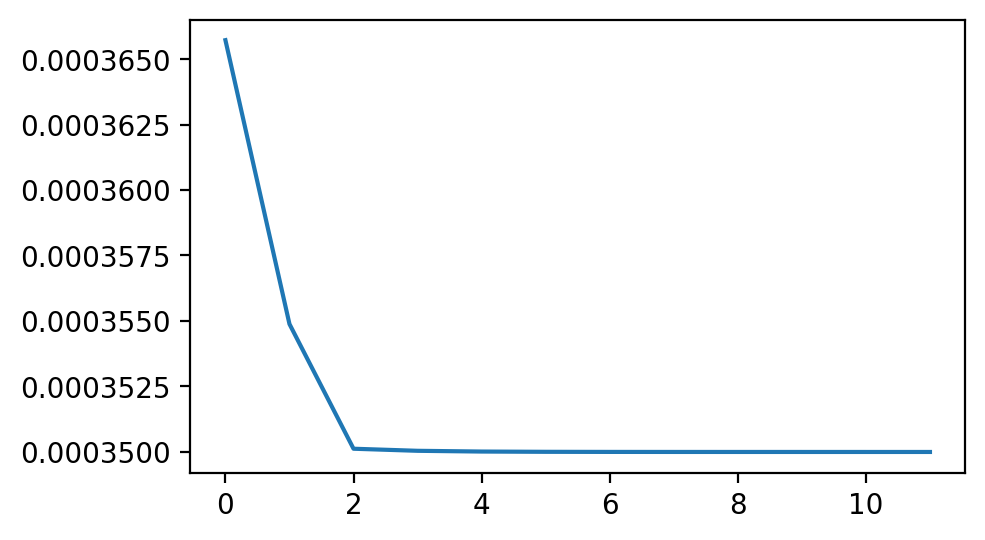

In [17]:
iterations = 20
myCS.executeCS(iterations)
myCS.plot_errors()

In [18]:
reconstructed , trainERROR , testERROR = myCS.return_signal_and_error()
reconstructed = np.real(reconstructed)
print('trainERROR: ',trainERROR)
print('testERROR: ',testERROR)

trainERROR:  (0.0003499839765277644+0j)
testERROR:  (0.7723087154125593+0j)


In [19]:
# play sound when finished
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

# inverse preprocessing

In [20]:
reconstructed -= reconstructed.mean()
reconstructed /= reconstructed.std()

reconstructed *= std
reconstructed += mean
reconstructed = np.minimum(np.maximum(reconstructed,0),1) # clamp to [0,1]

# display reconstructed result

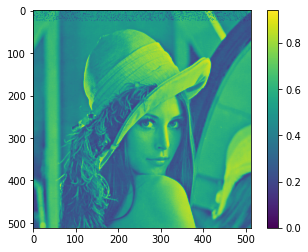

In [21]:
plt.imshow(reconstructed)
plt.colorbar()
plt.show()